Identifikasi : Blurred Image (Laplacian Var : 21.81)


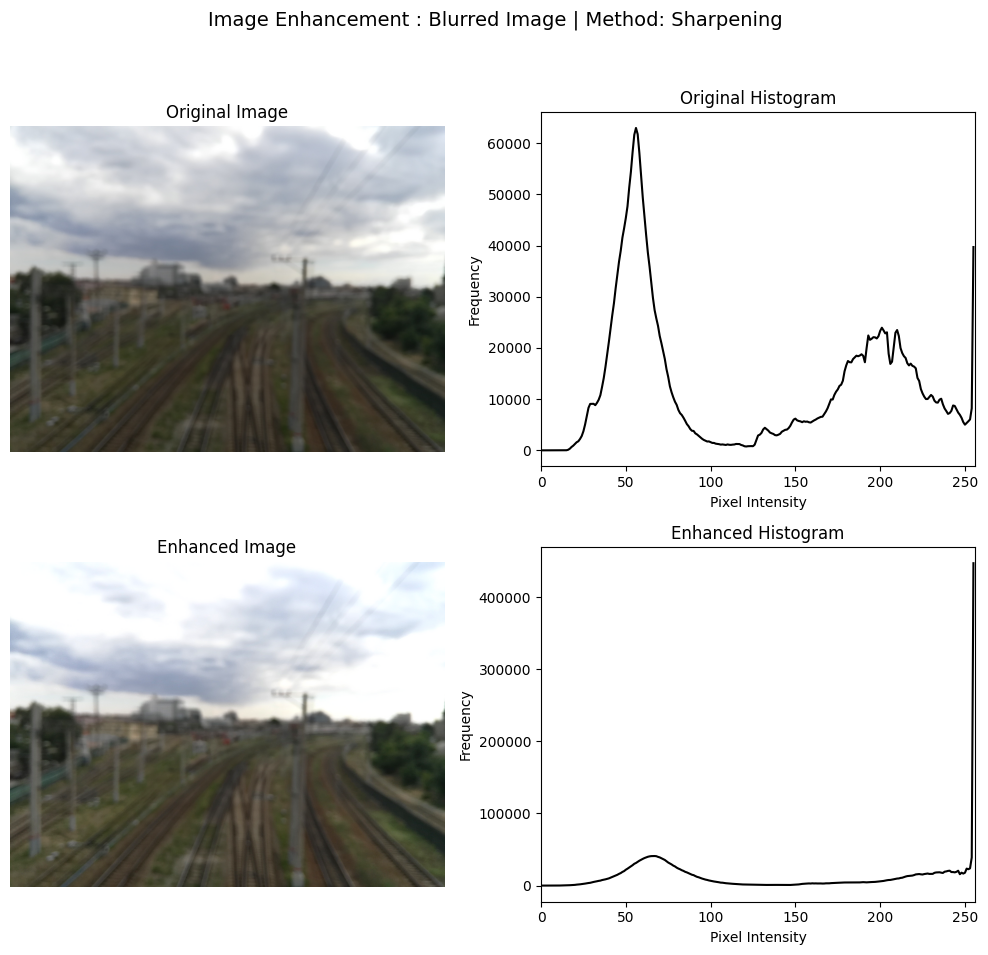

Gambar normal. Tidak ada masalah yang teridentifikasi.


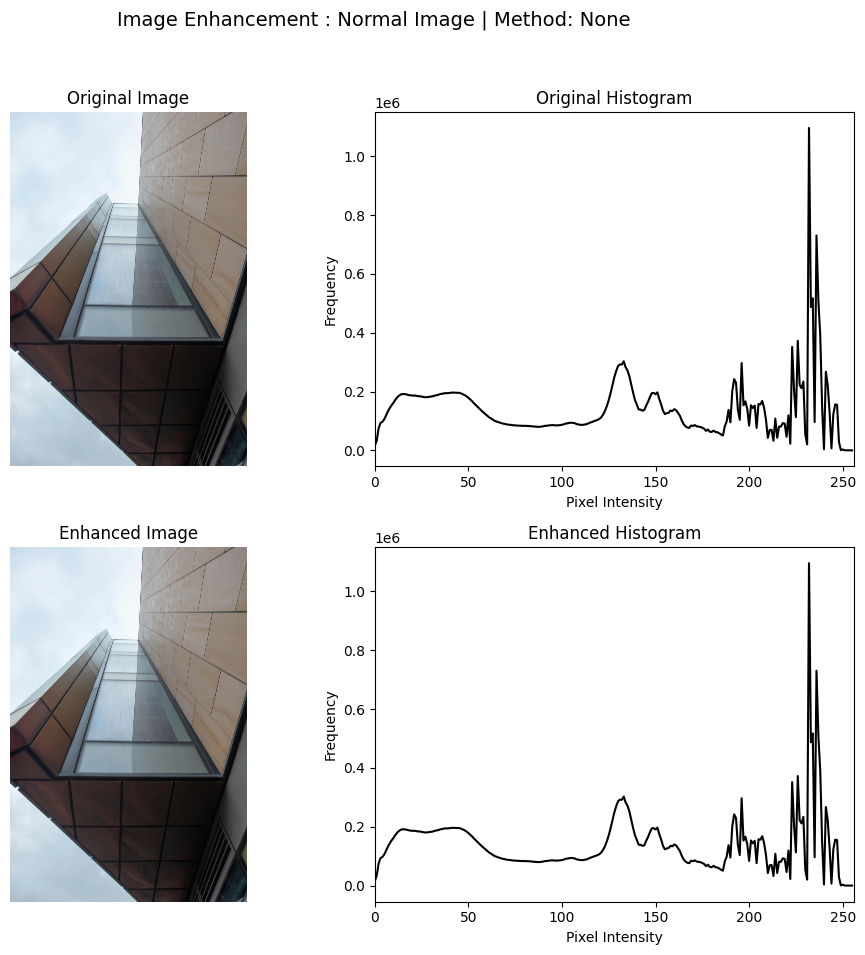

Identifikasi : Blurred Image (Laplacian Var : 51.10)


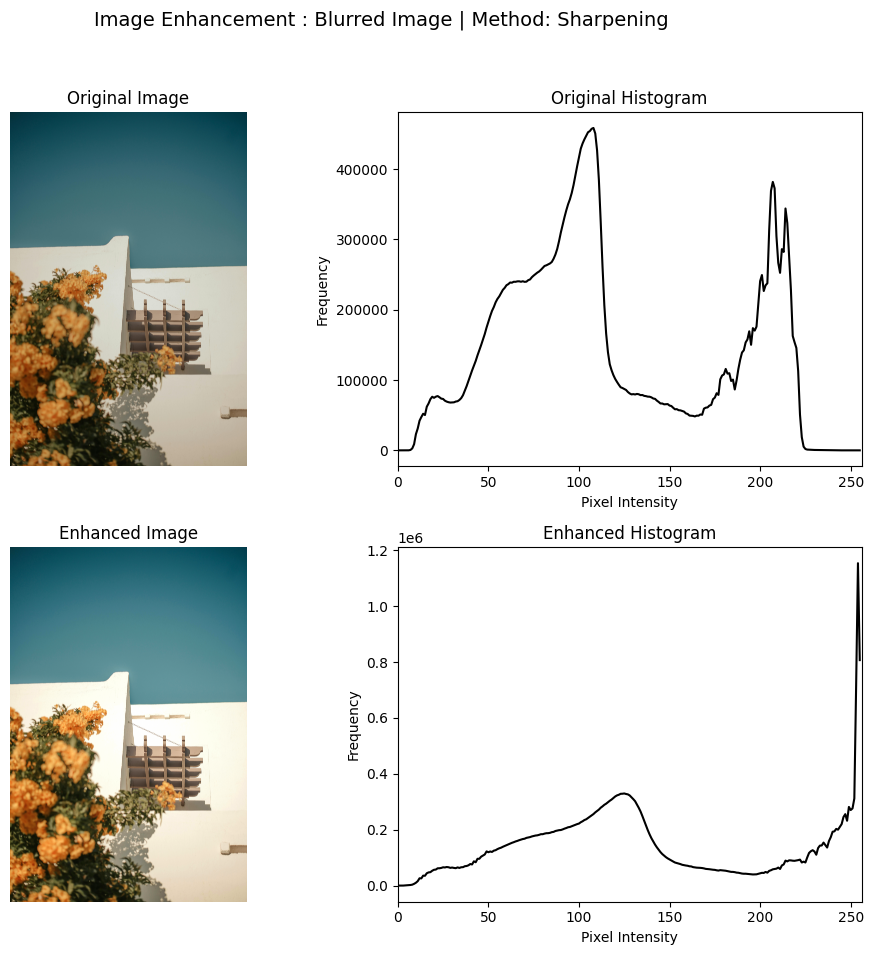

Identifikasi : Bright Object on Bright BG


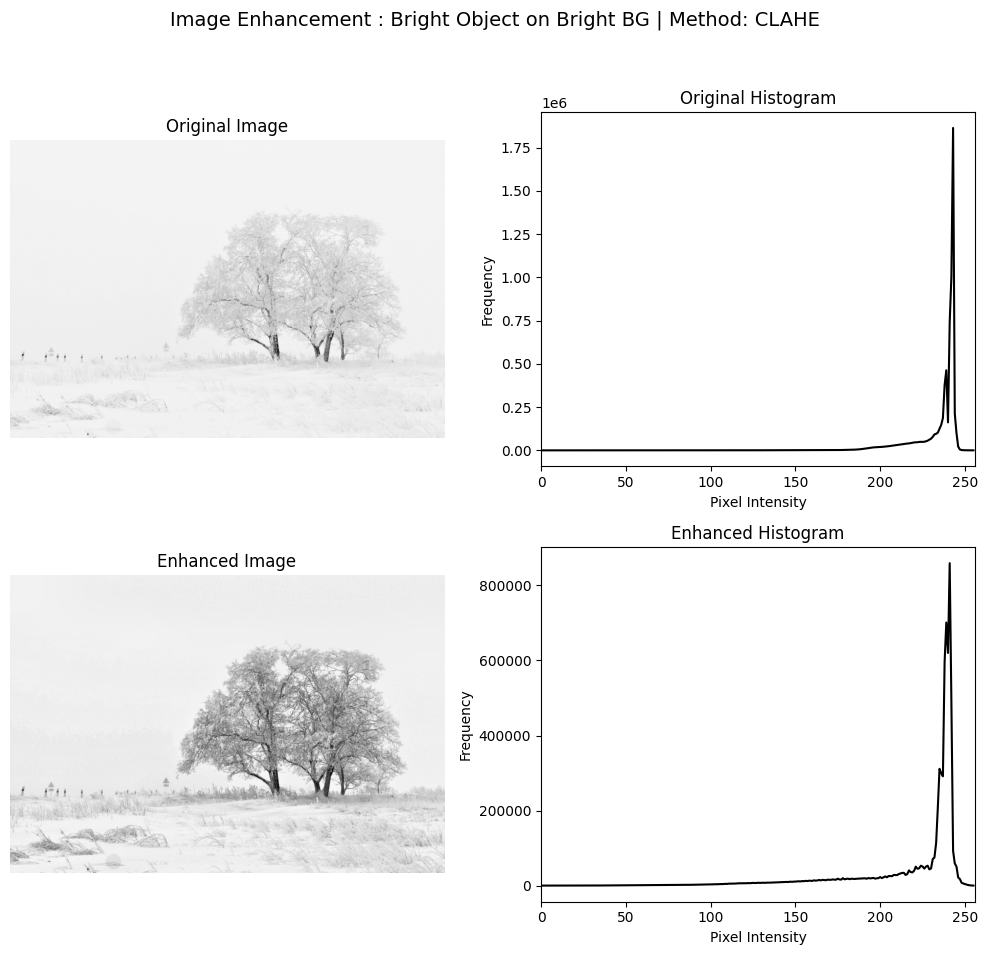

Identifikasi : Dark Object on Dark BG


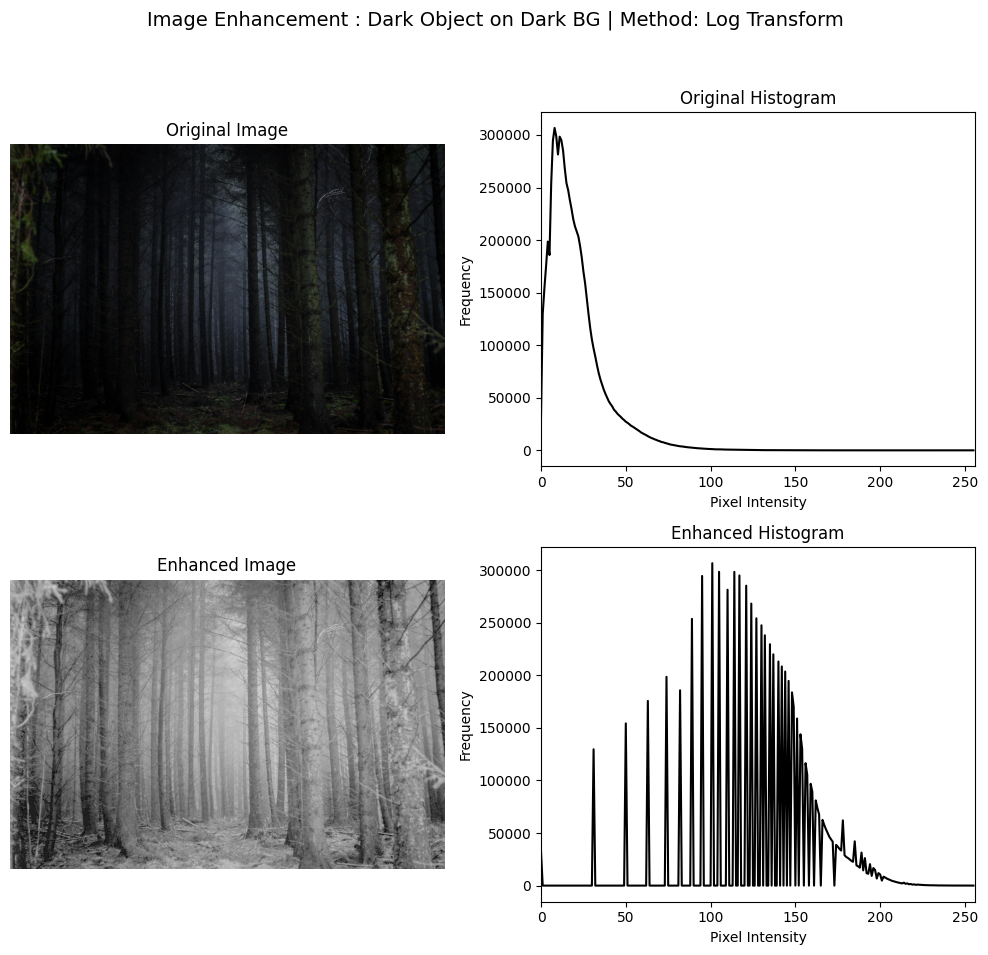

Identifikasi : Dark Object on Dark BG


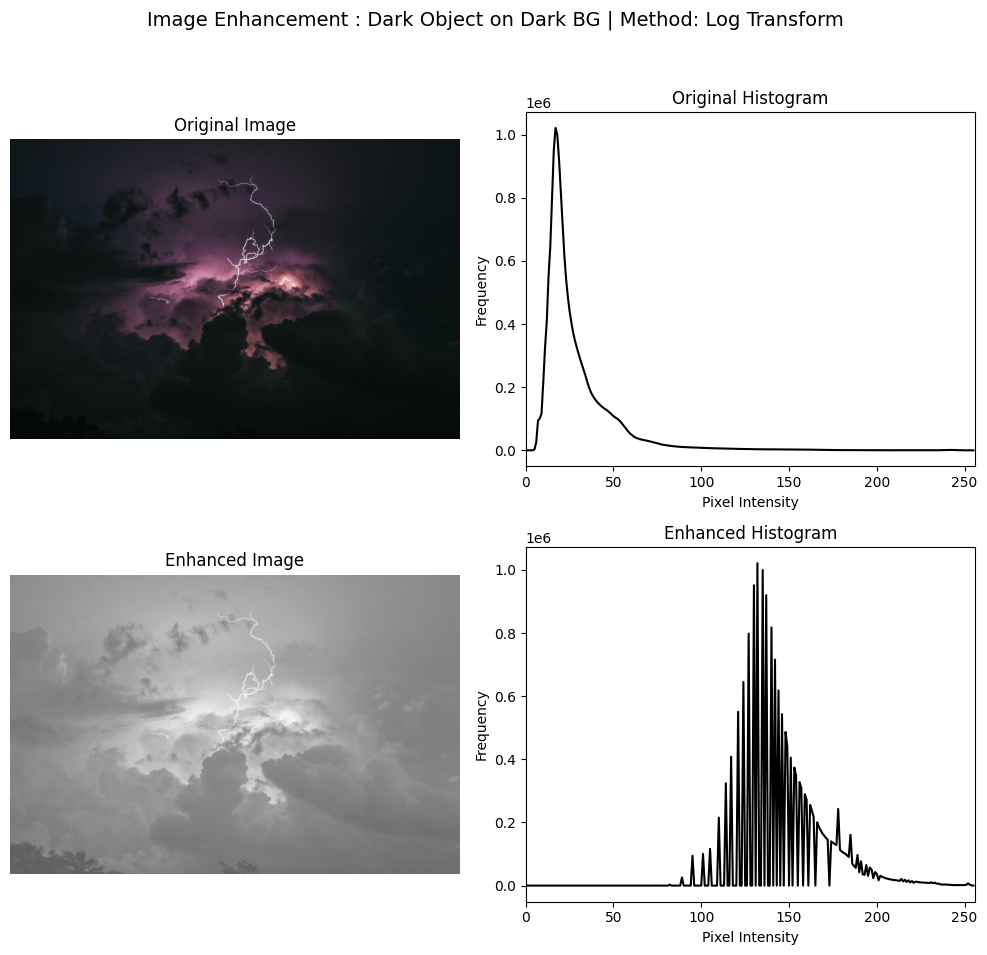

Identifikasi : Dark Object on Dark BG


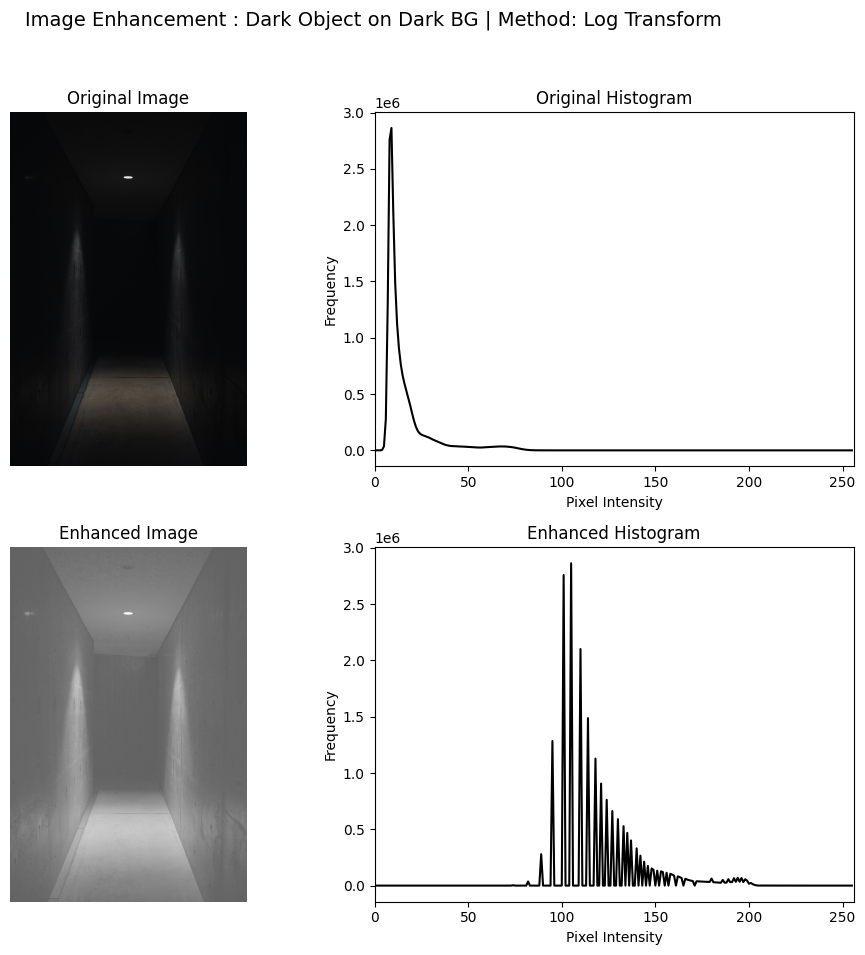

Identifikasi : Bright Image (Mean : 208.35)


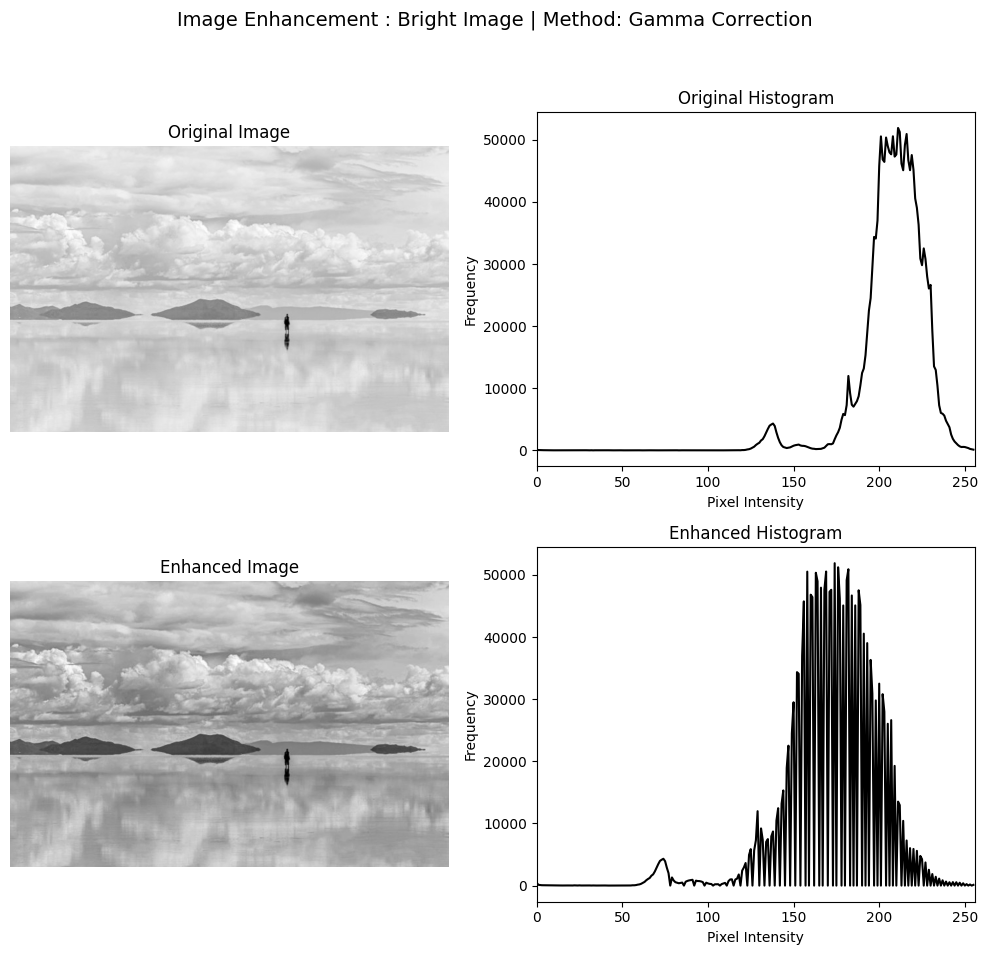

Identifikasi : Too Sharp (Laplacian Var : 5231.77)


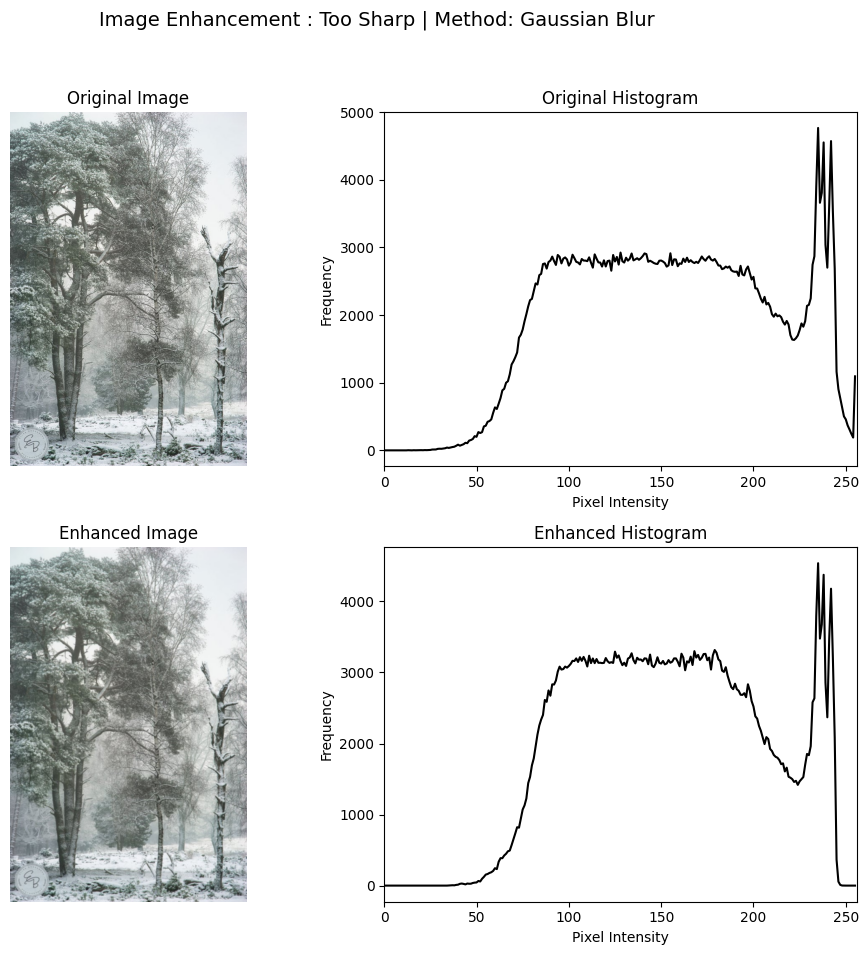

Identifikasi : Dark Object on Dark BG


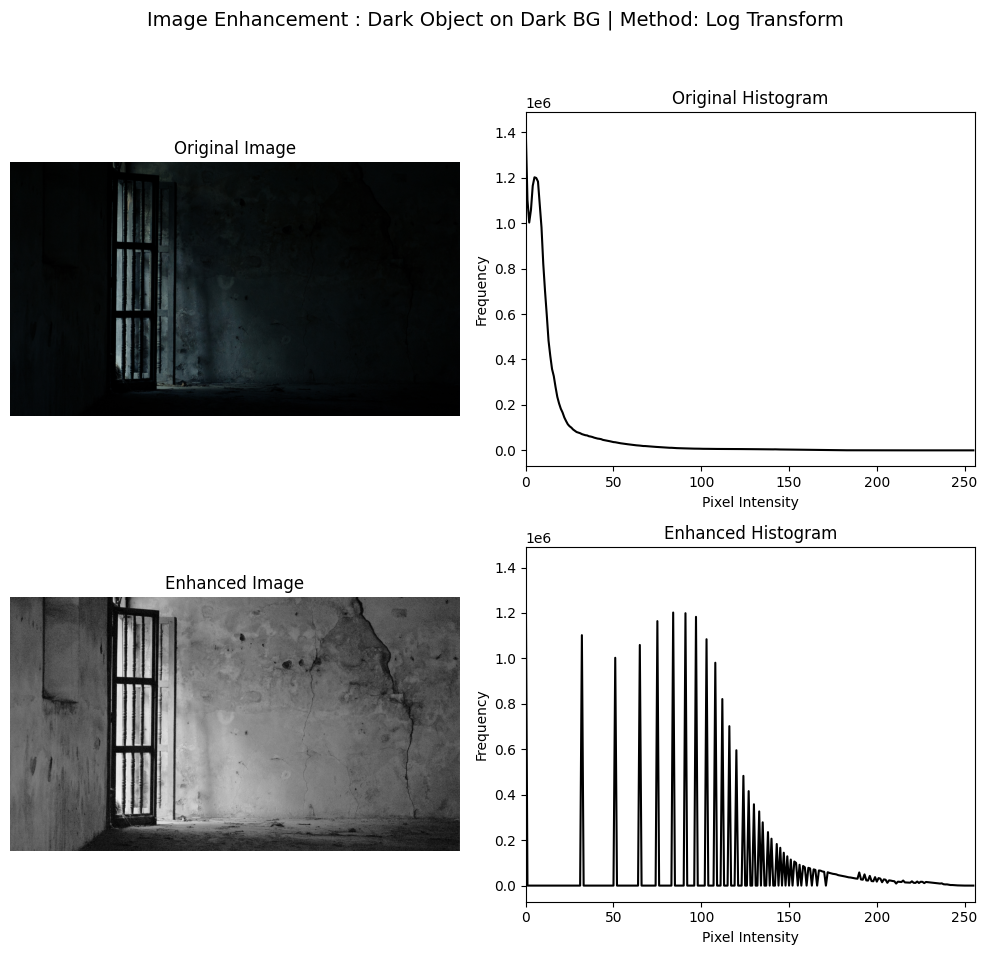

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def is_low_resolution(img, threshold=128*128):
    # Check if image is low resolution
    h, w = img.shape[:2]
    return h * w < threshold

def estimate_noise(img_gray):
    # Menggunakan perbedaan absolute antar pixel sebagai estimasi noise sederhana
    noise = np.mean(np.abs(img_gray.astype(np.float32) - cv2.medianBlur(img_gray, 3).astype(np.float32)))
    return noise

def is_too_sharp(img_gray, threshold=2000):
    # Jika variansi laplacian sangat tinggi, gambar terlalu tajam (over-sharpened)
    lap_var = cv2.Laplacian(img_gray, cv2.CV_64F).var()
    return lap_var > threshold

def is_dark_object_on_dark_bg(img_gray):
    # Deteksi objek gelap pada background gelap: mean rendah, tapi ada puncak histogram di intensitas rendah
    mean = np.mean(img_gray)
    hist = cv2.calcHist([img_gray],[0],None,[256],[0,256])
    dark_peak = np.argmax(hist[:50])
    return mean < 85 and dark_peak < 30

def is_bright_object_on_bright_bg(img_gray):
    # Deteksi objek terang pada background terang: mean tinggi, ada puncak histogram di intensitas tinggi
    mean = np.mean(img_gray)
    hist = cv2.calcHist([img_gray],[0],None,[256],[0,256])
    bright_peak = np.argmax(hist[200:])
    return mean > 170 and bright_peak > 40

def log_transform(img_gray):
    img_float = img_gray.astype(np.float32)
    c = 255 / np.log(1 + np.max(img_float))
    log_img = c * np.log(1 + img_float)
    log_img = np.clip(log_img, 0, 255).astype(np.uint8)
    return log_img

def img_enhancement(img_file):
    if not os.path.exists(img_file):
        print(f"File {img_file} tidak ditemukan.")
        return

    img_gray = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
    img_color = cv2.imread(img_file, cv2.IMREAD_COLOR)
    if img_gray is None or img_color is None:
        print("Error. Cek kembali nama file gambar!")
        return

    mean_value = np.mean(img_gray)
    std_dev = np.std(img_gray)
    laplacian_var = cv2.Laplacian(img_gray, cv2.CV_64F).var()
    noise_level = estimate_noise(img_gray)
    img_type = "Normal Image"
    enhanced_img = img_color.copy()
    enhancement_method = "None"

    # Multi-condition identification
    if is_low_resolution(img_gray):
        img_type = "Low Resolution"
        enhanced_img = cv2.resize(img_color, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
        enhancement_method = "Upsampling (Bicubic)"
        print(f"Identifikasi : {img_type} (Size : {img_gray.shape})")

    elif noise_level > 15:
        img_type = "Noisy Image"
        enhanced_img = cv2.fastNlMeansDenoisingColored(img_color, None, 10, 10, 7, 21)
        enhancement_method = "Non-local Means Denoising"
        print(f"Identifikasi : {img_type} (Noise level : {noise_level:.2f})")

    elif is_too_sharp(img_gray):
        img_type = "Too Sharp"
        enhanced_img = cv2.GaussianBlur(img_color, (3, 3), 1)
        enhancement_method = "Gaussian Blur"
        print(f"Identifikasi : {img_type} (Laplacian Var : {laplacian_var:.2f})")

    elif is_dark_object_on_dark_bg(img_gray):
        img_type = "Dark Object on Dark BG"
        log_img = log_transform(img_gray)
        enhanced_img = cv2.cvtColor(log_img, cv2.COLOR_GRAY2BGR)
        enhancement_method = "Log Transform"
        print(f"Identifikasi : {img_type}")

    elif is_bright_object_on_bright_bg(img_gray):
        img_type = "Bright Object on Bright BG"
        clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
        clahe_img = clahe.apply(img_gray)
        enhanced_img = cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2BGR)
        enhancement_method = "CLAHE"
        print(f"Identifikasi : {img_type}")

    elif mean_value < 60:
        img_type = "Dark Image"
        img_eq_hist = cv2.equalizeHist(img_gray)
        enhanced_img = cv2.cvtColor(img_eq_hist, cv2.COLOR_GRAY2BGR)
        enhancement_method = "Histogram Equalization"
        print(f"Identifikasi : {img_type} (Mean : {mean_value:.2f})")

    elif mean_value > 190:
        img_type = "Bright Image"
        gamma = 0.5
        inv_gamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
        enhanced_img = cv2.LUT(img_color, table)
        enhancement_method = "Gamma Correction"
        print(f"Identifikasi : {img_type} (Mean : {mean_value:.2f})")

    elif std_dev < 30:
        img_type = "Low Contrast Image"
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img_eq_hist = clahe.apply(img_gray)
        enhanced_img = cv2.cvtColor(img_eq_hist, cv2.COLOR_GRAY2BGR)
        enhancement_method = "CLAHE"
        print(f"Identifikasi : {img_type} (Std Dev : {std_dev:.2f})")

    elif laplacian_var < 100:
        img_type = "Blurred Image"
        # Sharpening kernel lebih optimal, gunakan kernel yang lebih baik
        kernel_sharpening = np.array([[0, -1, 0],
                                      [-1, 5.2, -1],
                                      [0, -1, 0]])
        enhanced_img = cv2.filter2D(img_color, -1, kernel_sharpening)
        enhancement_method = "Sharpening"
        print(f"Identifikasi : {img_type} (Laplacian Var : {laplacian_var:.2f})")

    else:
        print("Gambar normal. Tidak ada masalah yang teridentifikasi.")

    # Histogram sebelum dan sesudah enhancement
    hist_original = cv2.calcHist([img_gray], [0], None, [256], [0, 256])
    enhanced_gray = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2GRAY)
    hist_enhanced = cv2.calcHist([enhanced_gray], [0], None, [256], [0, 256])

    # Plot hasil
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    fig.suptitle(f"Image Enhancement : {img_type} | Method: {enhancement_method}", fontsize=14)

    axes[0, 0].imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')

    axes[0, 1].plot(hist_original, color='black')
    axes[0, 1].set_title('Original Histogram')
    axes[0, 1].set_xlabel('Pixel Intensity')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_xlim([0, 256])

    axes[1, 0].imshow(cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2RGB))
    axes[1, 0].set_title('Enhanced Image')
    axes[1, 0].axis('off')

    axes[1, 1].plot(hist_enhanced, color='black')
    axes[1, 1].set_title('Enhanced Histogram')
    axes[1, 1].set_xlabel('Pixel Intensity')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_xlim([0, 256])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

if __name__ == "__main__":
    img_name = [
        "1.jpg", "2.jpg", "3.jpg", "4.jpg", "5.jpg",
        "6.jpg", "7.jpg", "8.jpg", "9.jpg", "10.jpeg"
    ]
    for nama_file in img_name:
        img_enhancement(nama_file)

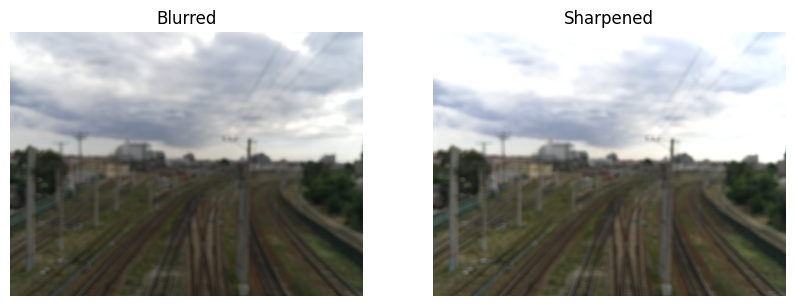

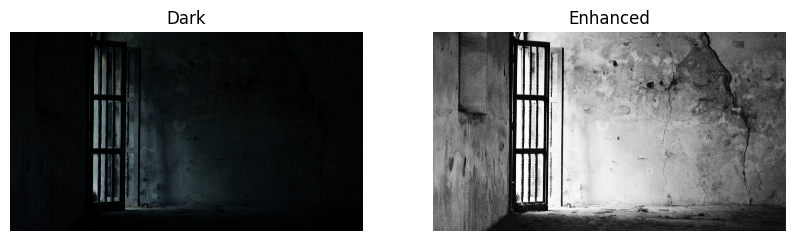

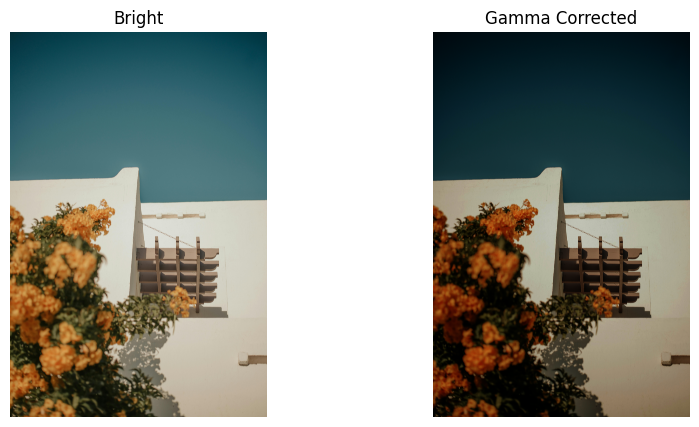

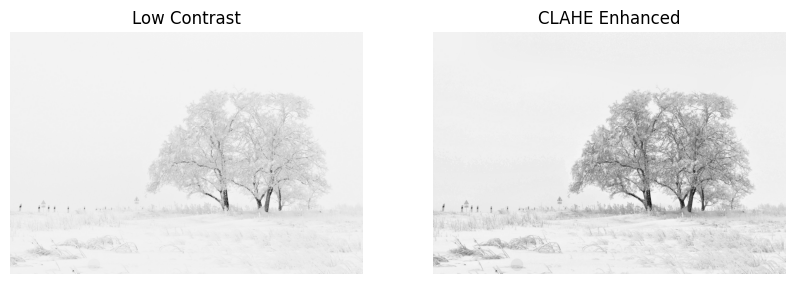

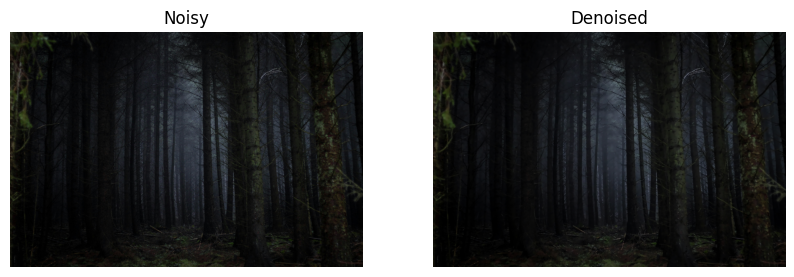

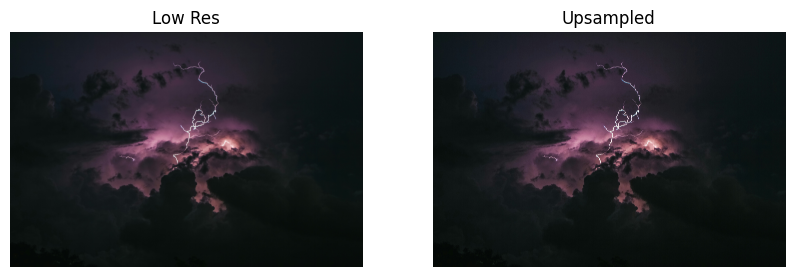

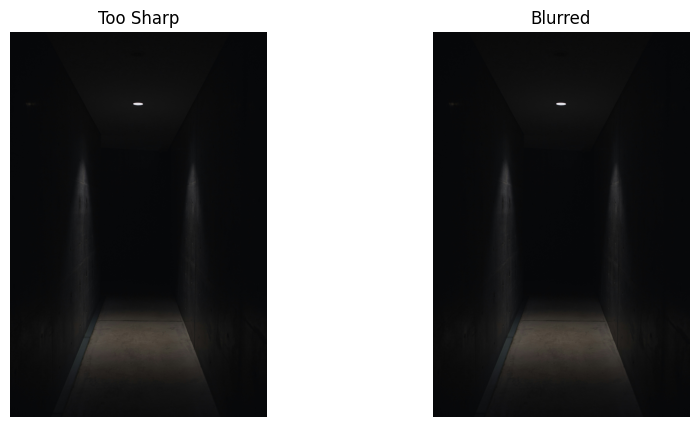

/tmp/ipython-input-1975581893.py:62: RuntimeWarning: overflow encountered in scalar add
  c = 255 / np.log(1 + np.max(gray))
/tmp/ipython-input-1975581893.py:62: RuntimeWarning: divide by zero encountered in log
  c = 255 / np.log(1 + np.max(gray))


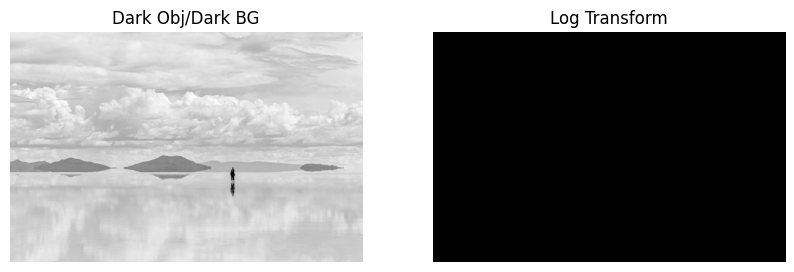

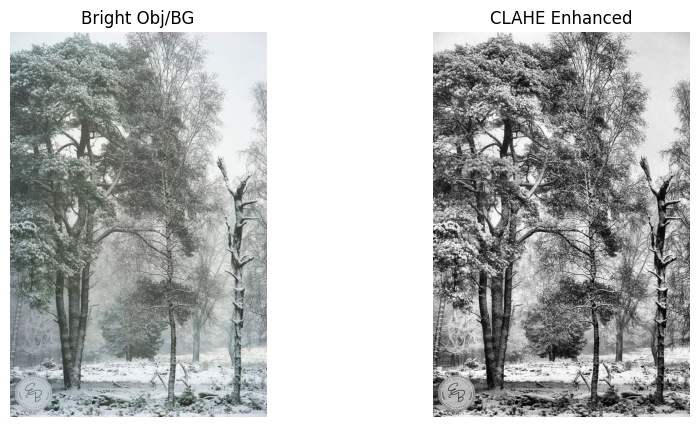

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_images(img1, img2, title1='Original', title2='Enhanced'):
  fig, axes = plt.subplots(1, 2, figsize=(10,5))
  axes[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
  axes[0].set_title(title1)
  axes[0].axis('off')
  axes[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
  axes[1].set_title(title2)
  axes[1].axis('off')
  plt.show()

# Blurred Image (Sharpening)
img_blur = cv2.imread('1.jpg')
kernel_sharpen = np.array([[0, -1, 0], [-1, 5.2, -1], [0, -1, 0]])
img_sharp = cv2.filter2D(img_blur, -1, kernel_sharpen)
show_images(img_blur, img_sharp, 'Blurred', 'Sharpened')

# Dark Image (Histogram Equalization)
img_dark = cv2.imread('10.jpeg')
gray = cv2.cvtColor(img_dark, cv2.COLOR_BGR2GRAY)
eq = cv2.equalizeHist(gray)
img_eq = cv2.cvtColor(eq, cv2.COLOR_GRAY2BGR)
show_images(img_dark, img_eq, 'Dark', 'Enhanced')

# Bright Image (Gamma Correction)
img_bright = cv2.imread('3.jpg')
gamma = 0.5
inv_gamma = 1.0 / gamma
table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype('uint8')
img_gamma = cv2.LUT(img_bright, table)
show_images(img_bright, img_gamma, 'Bright', 'Gamma Corrected')

# Low Contrast Image (CLAHE)
img_lowcont = cv2.imread('4.jpg')
gray = cv2.cvtColor(img_lowcont, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(gray)
img_clahe = cv2.cvtColor(cl1, cv2.COLOR_GRAY2BGR)
show_images(img_lowcont, img_clahe, 'Low Contrast', 'CLAHE Enhanced')

# Noisy Image (Denoising)
img_noisy = cv2.imread('5.jpg')
img_denoised = cv2.fastNlMeansDenoisingColored(img_noisy, None, 10, 10, 7, 21)
show_images(img_noisy, img_denoised, 'Noisy', 'Denoised')

# Low Resolution Image (Upsampling Bicubic)
img_lowres = cv2.imread('6.jpg')
img_upsampled = cv2.resize(img_lowres, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
show_images(img_lowres, img_upsampled, 'Low Res', 'Upsampled')

# Too Sharp Image (Gaussian Blur)
img_toosharp = cv2.imread('7.jpg')
img_blurred = cv2.GaussianBlur(img_toosharp, (3,3), 1)
show_images(img_toosharp, img_blurred, 'Too Sharp', 'Blurred')

# Dark Object on Dark Background (Log Transform)
img_darkobj = cv2.imread('8.jpg')
gray = cv2.cvtColor(img_darkobj, cv2.COLOR_BGR2GRAY)
c = 255 / np.log(1 + np.max(gray))
log_img = c * np.log(1 + gray.astype(np.float32))
log_img = np.clip(log_img, 0, 255).astype(np.uint8)
img_log = cv2.cvtColor(log_img, cv2.COLOR_GRAY2BGR)
show_images(img_darkobj, img_log, 'Dark Obj/Dark BG', 'Log Transform')

# Bright Object on Bright Background (CLAHE)
img_brightobj = cv2.imread('9.jpg')
gray = cv2.cvtColor(img_brightobj, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
cl1 = clahe.apply(gray)
img_clahe = cv2.cvtColor(cl1, cv2.COLOR_GRAY2BGR)
show_images(img_brightobj, img_clahe, 'Bright Obj/BG', 'CLAHE Enhanced')

In [1]:
#Impor library yang dibutuhkan
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

#Didefinisikan fungsi untuk menampilkan image input dan menyimpan image output
def show_and_save(img_input, img_output, output_path, title_input='Original Image', title_output='Enhanced Image'):
  #Setting image dan histogram
  fig, axes = plt.subplots(2, 2, figsize=(10,8))

  #Image
  axes[0,0].imshow(cv2.cvtColor(img_input, cv2.COLOR_BGR2RGB))
  axes[0,0].set_title(title_input)
  axes[0,0].axis('off')
  axes[0,1].imshow(cv2.cvtColor(img_output, cv2.COLOR_BGR2RGB))
  axes[0,1].set_title(title_output)
  axes[0,1].axis('off')

  #Histogram
  gray_input = cv2.cvtColor(img_input, cv2.COLOR_BGR2GRAY)
  gray_output = cv2.cvtColor(img_output, cv2.COLOR_BGR2GRAY)
  axes[1,0].hist(gray_input.flatten(), bins=256, color='gray')
  axes[1,0].set_title('Histogram (Original)')
  axes[1,1].hist(gray_output.flatten(), bins=256, color='gray')
  axes[1,1].set_title('Histogram (Enhanced)')
  plt.tight_layout()
  plt.show()

  #Simpan hasil output
  cv2.imwrite(output_path, img_output)
  print(f"Hasil disimpan di : {output_path}")

#Cek folder output
os.makedirs('output', exist_ok=True)  #Output disimpan di folder output ini

# Blurred Image (Sharpening)
img_blur = cv2.imread('1.jpg')
if img_blur is not None:
    kernel_sharpen = np.array([[0, -1, 0], [-1, 5.2, -1], [0, -1, 0]])
    img_sharp = cv2.filter2D(img_blur, -1, kernel_sharpen)
    show_and_save(img_blur, img_sharp, 'output/enhanced_blur.jpg', 'Original Image', 'Enhanced Image')
else:
    print("Error loading 1.jpg")


#Dark Image (Histogram Equalization)
img_dark = cv2.imread('10.jpeg')
if img_dark is not None:
    gray = cv2.cvtColor(img_dark, cv2.COLOR_BGR2GRAY)
    eq = cv2.equalizeHist(gray)
    img_eq = cv2.cvtColor(eq, cv2.COLOR_GRAY2BGR)
    show_and_save(img_dark, img_eq, 'output/enhanced_dark.jpg', 'Original Image', 'Enhanced Image')
else:
    print("Error loading 10.jpeg")


#Bright Image (Gamma Correction)
img_bright = cv2.imread('3.jpg')
if img_bright is not None:
    gamma = 0.5
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype('uint8')
    img_gamma = cv2.LUT(img_bright, table)
    show_and_save(img_bright, img_gamma, 'output/enhanced_bright.jpg', 'Original Image', 'Enhanced Image')
else:
    print("Error loading 3.jpg")

#Low Contrast Image (CLAHE)
img_lowcont = cv2.imread('4.jpg')
if img_lowcont is not None:
    gray = cv2.cvtColor(img_lowcont, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(gray)
    img_clahe = cv2.cvtColor(cl1, cv2.COLOR_GRAY2BGR)
    show_and_save(img_lowcont, img_clahe, 'output/enhanced_lowcontrast.jpg', 'Original Image', 'Enhanced Image')
else:
    print("Error loading 4.jpg")

#Noisy Image (Denoising)
img_noisy = cv2.imread('5.jpg')
if img_noisy is not None:
    img_denoised = cv2.fastNlMeansDenoisingColored(img_noisy, None, 10, 10, 7, 21)
    show_and_save(img_noisy, img_denoised, 'output/enhanced_noisy.jpg', 'Original Image', 'Enhanced Image')
else:
    print("Error loading 5.jpg")

#Low Resolution Image (Upsampling Bicubic)
img_lowres = cv2.imread('6.jpg')
if img_lowres is not None:
    img_upsampled = cv2.resize(img_lowres, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    show_and_save(img_lowres, img_upsampled, 'output/enhanced_lowres.jpg', 'Original Image', 'Enhanced Image')
else:
    print("Error loading 6.jpg")

#Too Sharp Image (Gaussian Blur)
img_toosharp = cv2.imread('7.jpg')
if img_toosharp is not None:
    img_blurred = cv2.GaussianBlur(img_toosharp, (3,3), 1)
    show_and_save(img_toosharp, img_blurred, 'output/enhanced_toosharp.jpg', 'Original Image', 'Enhanced Image')
else:
    print("Error loading 7.jpg")

#Dark Object on Dark Background (Log Transform)
img_darkobj = cv2.imread('8.jpg')
if img_darkobj is not None:
    gray = cv2.cvtColor(img_darkobj, cv2.COLOR_BGR2GRAY)
    #Mencegah kemungkinan log(0) atau log(negative)
    max_val = np.max(gray)
    if max_val > 0:
        c = 255 / np.log(1 + max_val)
        log_img = c * np.log(1 + gray.astype(np.float32))
        log_img = np.clip(log_img, 0, 255).astype(np.uint8)
        img_log = cv2.cvtColor(log_img, cv2.COLOR_GRAY2BGR)
        show_and_save(img_darkobj, img_log, 'output/enhanced_darkobject.jpg', 'Original Image', 'Enhanced Image')
    else:
        print("Image is completely dark, cannot apply log transform.")
else:
    print("Error loading 8.jpg")

#Bright Object on Bright Background (CLAHE)
img_brightobj = cv2.imread('9.jpg')
if img_brightobj is not None:
    gray = cv2.cvtColor(img_brightobj, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
    cl1 = clahe.apply(gray)
    img_clahe = cv2.cvtColor(cl1, cv2.COLOR_GRAY2BGR)
    show_and_save(img_brightobj, img_clahe, 'output/enhanced_brightobject.jpg', 'Original Image', 'Enhanced Image')
else:
    print("Error loading 9.jpg")

Error loading 1.jpg
Error loading 10.jpeg
Error loading 3.jpg
Error loading 4.jpg
Error loading 5.jpg
Error loading 6.jpg
Error loading 7.jpg
Error loading 8.jpg
Error loading 9.jpg
